# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import scipy
import sys
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps
import copy
import glob

In [37]:
# locate input data
micapipe_dir = '../../publication-hippomaps/sourcedata/Supersession_PNI'
hippunfold_dir = '../../publication-hippomaps/hippunfold/PNI_v1.3.0_super/hippunfold'

# define which subjects and surfaces to examine
subs_7T = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den = '0p5mm'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25) 
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0]

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# loop through these types of structural images
features_7T = ['qT1','MTR','T2star','FA','ADC']

# 0) Map volumetric data to surfaces and load (optional) 

This code may differ depending on where/how your data is stored and formatted, and so should be seen as an example. For the purposes of this tutorial, we provide a matrix of loaded data at the end, so skip to step 1).

In this example, we loop through subjects, hemipsheres, and generate surfaces at different depths using the `wb_command` tool. Then, we loop through each modality and sample the data to those surfaces. Finally, we load the data from all surfaces into a single matrix.

In [15]:
# Note that all data is already aligned in space-T1w AKA space-nativepro!

# intialize the matrix for loading data into
hipp_dat_7T = np.zeros([nV,len(hemis),len(subs),len(depths),len(features)])*np.nan 
!mkdir -p tmp # store intermediate files temporarily

for s,sub in enumerate(subs_7T):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            for d,depth in enumerate(depths):
                
                # create surface depths
                cmd1 = f'wb_command -surface-cortex-layer '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_inner.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_outer.surf.gii '\
                    f'{depth} '\
                    f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}.surf.gii'
                !{cmd1}
                
                # sample data to each surface
                for f,feature in enumerate(features_7T):
                    cmd2 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                        f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}.surf.gii '\
                        f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}_{feature}.shape.gii '\
                        f'-trilinear'
                    !{cmd2}
                    
                    # now load the data!
                    surfdata = nib.load(f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}_{feature}.shape.gii')
                    hipp_dat_7T[iV[l],h,s,d,f] = surfdata.darrays[0].data
                    
    print(f'sub-{sub} done')

np.save("../checkpoints/MRI-7T-strucut_unproc",hipp_dat_7T)
!rm -rf tmp

sub-PNC002 done
sub-PNC003 done
sub-PNC006 done
sub-PNC007 done
sub-PNC009 done
sub-PNC010 done
sub-PNC015 done
sub-PNC016 done
sub-PNC018 done
sub-PNC019 done


# 1) Load and plot all surface data

Here, we use the data already loaded into a large matrix from step 0). This matrix `hipp_dat_7T` has a shape of (number of vertices nV) x (number of hemsipheres 2) x (number of subjects) x (number of surface depths) x (number of features or image types)

In [ ]:
# Load data
hipp_dat_7T = np.load("../checkpoints/MRI-7T-strucut_unproc.npy")

# Preprocess
# Profile align the depths of each column (as in https://github.com/jordandekraker/hippomaps/blob/master/tutorials/Histology-MRI-9p4T.ipynb)
for f,feature in enumerate(features_7T):
    for s,sub in enumerate(subs_7T):
        for h,hemi in enumerate(hemis):  
            hipp_dat_7T[:,h,s,:,f] = hm.utils.profile_align(hipp_dat_7T[:,h,s,:,f])

Now lets use our plotting tools to make a nice plot, averaging across depths and hemispheres and subjects

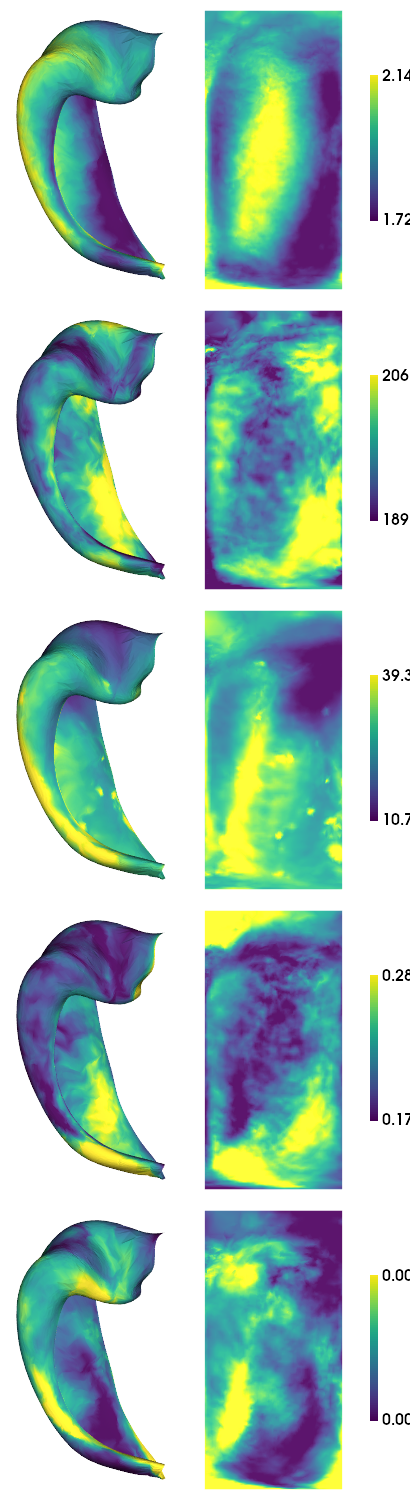

In [17]:
cdata = hipp_dat_7T[:,:,:,gm,:] # trim the data that is not actually inside our grey matter bound
cdata = np.nanmean(cdata,axis=(1,2,3)) # average over subjects, hemispheres, and depths for visualization
hm.plotting.surfplot_canonical_foldunfold(cdata, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

## 2) stability between subjects

To make sure our measures are consistent, we will check whether they are correlated across samples (that is, across subjects and hemipsheres)

In [25]:
# again average across depths for a given feature (feature 0 )
cdata = np.nanmean(hipp_dat_7T[:,:,:,gm,0],axis=3)
# reshape so subject hemispheres are listed in the same dimension
cdata = cdata.reshape((7262,-1))
cdata.shape

(7262, 20)

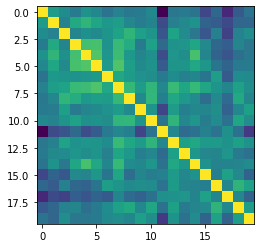

In [26]:
# now we can see the vertex-wise correlation between all 20 subject hemispheres
plt.imshow(np.corrcoef(cdata.T))

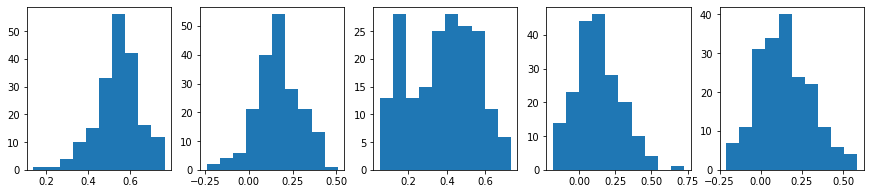

In [27]:
# now repeat for all features and make a histogram of the off-diagonal values
mfcorr = []
sdfcorr = []
fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(3*len(features),3))
for f,feature in enumerate(features):
    cdat = np.nanmean(hipp_dat_7T[:,:,:,gm,f],axis=3).reshape((7262,-1)) # as above
    corr = np.corrcoef(cdat.T) # as above 2
    fcorr = corr[np.triu_indices(20,k=1)] # this return only the off-diagonal (lower left triangle)
    ax[f].hist(fcorr) # make a histogram for this particular feature
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

These are some nice correlations; consistently above zero!

## 3) lets add another dataset (9.4T data)

In this case, data was samples on a denser surface (`den='unfoldiso'`). Thus we will have to interpolate it to the `den='0p5mm'` surfaces that we've been using so far

In [30]:
# add in 9.4T data that we already preprocessed in https://github.com/jordandekraker/hippomaps/blob/master/tutorials/Histology-MRI-9p4T.ipynb

features_9p4T = ['PD', 'R1', 'R2star']
subs_9p4T = ['122017', '152017']
hemis = ['L','R']

tmp = np.load("../checkpoints/struct-HISTO-proc.npy")[:,:,-4*3:] # only the last set of 12 maps are from 9.4T MRI; the others are from histology and so we will discard them

# downsample to 0p5mm and format as above
hipp_dat_9p4T = np.zeros([nV,len(hemis),len(subs),len(depths),len(features_9p4T)])*np.nan 
# resample
for d,depth in enumerate(depths):
    n=0
    for f,featue in enumerate(features_9p4T):
        for s,sub in enumerate(subs_9p4T):
            for h,hemi in enumerate(hemis):
                hipp_dat_9p4T[:,h,s,d,f],_,_ = hm.utils.density_interp('unfoldiso','0p5mm',tmp[:,d,n],'hipp')
                n=n+1

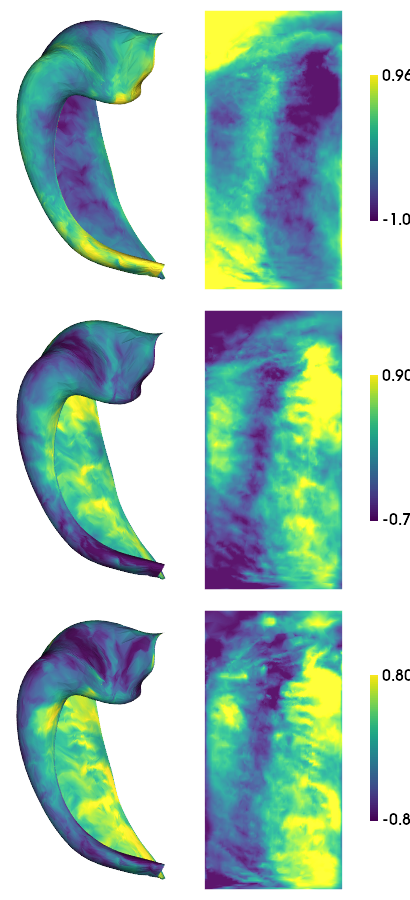

In [31]:
cdata = hipp_dat_9p4T[:,:,:,gm,:] # trim the data that is not actually inside our grey matter bound
cdata = np.nanmean(cdata,axis=(1,2,3)) # average over subjects, hemispheres, and depths for visualization
hm.plotting.surfplot_canonical_foldunfold(cdata, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

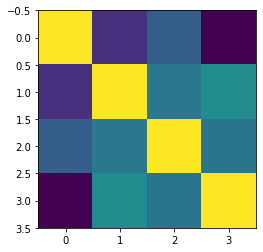

In [32]:
plt.imshow(np.corrcoef(np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=3).reshape((7262,-1)).T))

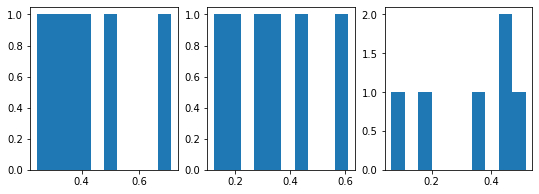

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=len(features_9p4T), figsize=(3*len(features_9p4T),3))
for f,feature in enumerate(features_9p4T):
    cdat = np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=3).reshape((7262,-1))
    corr = np.corrcoef(cdat.T)
    fcorr = corr[np.triu_indices(4,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

Not as nice looking as before, since we only have 4 samples to look at. But still correlations are well above zero!

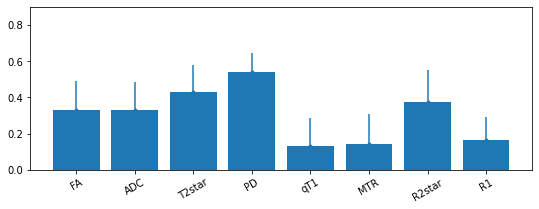

In [38]:
# make a nice plot

# combine the two datasets
xnames = features_9p4T + features_7T
# reorder to match what's written in the manuscript
myorder=[6,7,5,0,3,4,2,1]
xnames = [xnames[i] for i in myorder]
mfcorr = [mfcorr[i] for i in myorder]
sdfcorr = [sdfcorr[i] for i in myorder]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(features_9p4T),3))
plt.bar(range(8),mfcorr)
plt.errorbar(range(8),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(8),labels=xnames,rotation=30)
plt.ylim([0,.9]);

## gradients

In [39]:
modality_data = np.concatenate((np.nanmean(hipp_dat_9p4T,axis=(1,2)),np.nanmean(hipp_dat_7T,axis=(1,2))),axis=2)
modality_data.shape

(7262, 25, 8)

In [40]:
MP = np.reshape(modality_data[:,gm,:],(7262,-1)).T
MPC, I, problemNodes = build_mpc(np.concatenate((MP,np.mean(MP,axis=0).reshape((1,-1)))))

/data/mica1/01_programs/micapipe-v0.2.0/functions/build_mpc.py:116: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 7261.5, 7261.5, -0.5)

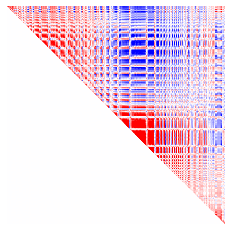

In [41]:
plt.imshow(MPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [42]:
# gradient decomposition
mmgm = GradientMaps(n_components=5)
mmgm.fit(MPC)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(n_components=5)

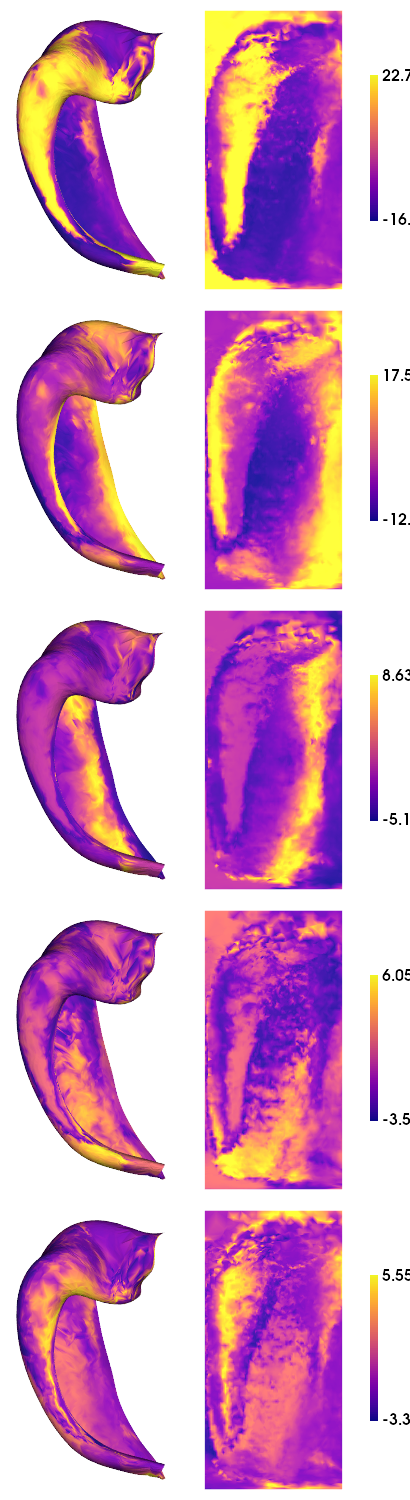

In [44]:
hm.plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, den='0p5mm', cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

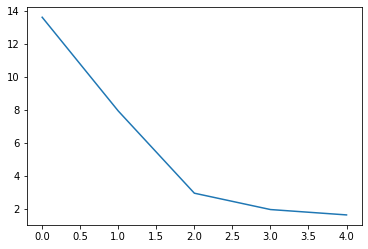

In [45]:
plt.plot(mmgm.lambdas_)

In [46]:
mmgm.lambdas_/np.sum(mmgm.lambdas_)

array([0.48416778, 0.28227002, 0.1051938 , 0.06996862, 0.05839978])

## save

In [ ]:
# save 2D map
for f,feature in enumerate(features_7T):
    cdat = np.nanmean(hipp_dat_7T[:,:,:,gm,f],axis=(1,2,3)).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-{feature}_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii')

In [ ]:
# save 2D map
for f,feature in enumerate(features_9p4T):
    cdat = np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=(1,2,3)).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-{feature}_average-4_hemi-mix_den-0p5mm_label-hipp.shape.gii')

In [ ]:
# save everything
import shelve
filename='../checkpoints/MRI-7T-struct.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()